### Question: does `model` returns `[0 prob, 1 prob]` before softmax?

In [1]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    AutoConfig,
    TextClassificationPipeline,
)
from engine.data import prepare_data_for_fine_tuning, read_data
from engine.xai import FeatureAblationText
import pandas as pd

c:\Users\1234o\Studies\Sem2\NLP\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_ID = "roberta-base"
MODEL_PATH = "output/checkpoint-2025/model.safetensors"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

In [3]:
test = pd.read_csv("data/liar/test.csv")
# print(test)
test_dataset = prepare_data_for_fine_tuning(test, tokenizer)

Map: 100%|██████████| 795/795 [00:00<00:00, 4745.36 examples/s]


In [4]:
import torch
def get_device():
    if torch.cuda.is_available():
        print("CUDA is available. Using GPU.")
        return "cuda"
    else:
        print("CUDA not available. Using CPU.")
        return "cpu"

In [5]:
config = AutoConfig.from_pretrained(MODEL_ID)
device = get_device()
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_PATH, config=config
)
model.eval()
pipeline = TextClassificationPipeline(
    model=model, tokenizer=tokenizer, top_k=2, device=device
)

CUDA not available. Using CPU.


In [6]:
%%capture
if(device == "cuda"):
    model.cuda()
else:
    model.cpu()

In [7]:
obs = test["text"].tolist()[579]
if(device == "cuda"):
    obs_pt = pipeline.tokenizer(obs, return_tensors="pt")['input_ids'].cuda()
else:
    obs_pt = pipeline.tokenizer(obs, return_tensors="pt")['input_ids'].cpu()

print(obs)
print(obs_pt)


Fifty-six percent decline in overall crime. A 73 percent decline in motor-vehicle theft. A 67 percent decline in robbery. A 66 percent decline in murder. This is way beyond what happened in the nation during this period of time.
tensor([[    0,   597, 22129,    12, 13664,   135,  2991,    11,  1374,  1846,
             4,    83,  6521,   135,  2991,    11,  4243,    12, 17855, 11317,
          5751,     4,    83,  5545,   135,  2991,    11,  6279,     4,    83,
          5138,   135,  2991,    11,  1900,     4,   152,    16,   169,  1684,
            99,  1102,    11,     5,  1226,   148,    42,   675,     9,    86,
             4,     2]])


In [8]:
def forward(obs):
    return model(obs).logits

In [9]:

attr = FeatureAblationText(forward)
print(attr)
exp = attr.get_attributions([obs_pt])
exp

tensor([[[ 0.0000e+00,  4.9621e-06,  8.8066e-06,  3.8594e-06,  7.4357e-06,
           1.0684e-05,  1.0982e-05,  7.3612e-06,  9.5218e-06,  4.0531e-06,
           4.0382e-06,  4.1127e-06,  3.5316e-06,  1.0267e-05,  1.1295e-05,
           8.1062e-06,  4.1127e-06,  6.2287e-06,  1.0163e-05,  1.0222e-05,
           2.2799e-06,  4.5598e-06,  4.2915e-06,  2.1160e-06,  8.4639e-06,
           9.8199e-06,  5.2899e-06,  1.5199e-06,  2.6524e-06,  2.3842e-06,
           1.7881e-07,  5.2899e-06,  5.3346e-06,  5.0664e-07, -3.5316e-06,
          -2.3991e-06,  2.8312e-07, -5.9605e-07, -3.4273e-07,  2.1309e-06,
          -4.1723e-07, -1.4901e-07,  1.5646e-06, -1.7881e-06,  2.2352e-07,
           2.9057e-06,  1.6242e-06,  6.5714e-06,  4.1276e-06,  5.6922e-06,
           2.8908e-06,  1.1623e-06],
         [ 0.0000e+00,  2.0303e-07,  1.2014e-06, -1.3970e-07,  5.7742e-08,
           1.2778e-06,  1.4901e-06,  6.3702e-07,  2.1160e-06, -1.7881e-07,
          -1.3039e-07, -7.2643e-08, -5.3644e-07,  1.7211e-06,  

In [10]:
tokens = pipeline.tokenizer.convert_ids_to_tokens(obs_pt[0])
print(tokens)

['<s>', 'F', 'ifty', '-', 'six', 'Ġpercent', 'Ġdecline', 'Ġin', 'Ġoverall', 'Ġcrime', '.', 'ĠA', 'Ġ73', 'Ġpercent', 'Ġdecline', 'Ġin', 'Ġmotor', '-', 'veh', 'icle', 'Ġtheft', '.', 'ĠA', 'Ġ67', 'Ġpercent', 'Ġdecline', 'Ġin', 'Ġrobbery', '.', 'ĠA', 'Ġ66', 'Ġpercent', 'Ġdecline', 'Ġin', 'Ġmurder', '.', 'ĠThis', 'Ġis', 'Ġway', 'Ġbeyond', 'Ġwhat', 'Ġhappened', 'Ġin', 'Ġthe', 'Ġnation', 'Ġduring', 'Ġthis', 'Ġperiod', 'Ġof', 'Ġtime', '.', '</s>']


In [11]:
import spacy

NER = spacy.load("en_core_web_sm")

doc = NER(obs)

print("Entities in the text:")
for ent in doc.ents:
    print(f"{ent.text} ({ent.label_}) - {spacy.explain(ent.label_)}")

Entities in the text:
Fifty-six percent (PERCENT) - Percentage, including "%"
73 percent (PERCENT) - Percentage, including "%"
67 percent (PERCENT) - Percentage, including "%"
66 percent (PERCENT) - Percentage, including "%"


In [12]:
print("\nTokens and Their NER Information: \n")

for token in doc:
    if token.ent_type_:
        print(f"Token: {token.text}, Entity Type: {token.ent_type_} ({spacy.explain(token.ent_type_)})")
    else:
        print(f"Token: {token.text}, Not part of any entity.")


Tokens and Their NER Information: 

Token: Fifty, Entity Type: PERCENT (Percentage, including "%")
Token: -, Entity Type: PERCENT (Percentage, including "%")
Token: six, Entity Type: PERCENT (Percentage, including "%")
Token: percent, Entity Type: PERCENT (Percentage, including "%")
Token: decline, Not part of any entity.
Token: in, Not part of any entity.
Token: overall, Not part of any entity.
Token: crime, Not part of any entity.
Token: ., Not part of any entity.
Token: A, Not part of any entity.
Token: 73, Entity Type: PERCENT (Percentage, including "%")
Token: percent, Entity Type: PERCENT (Percentage, including "%")
Token: decline, Not part of any entity.
Token: in, Not part of any entity.
Token: motor, Not part of any entity.
Token: -, Not part of any entity.
Token: vehicle, Not part of any entity.
Token: theft, Not part of any entity.
Token: ., Not part of any entity.
Token: A, Not part of any entity.
Token: 67, Entity Type: PERCENT (Percentage, including "%")
Token: percent, 

In [13]:
print(len(tokens))

tokens_clear = [s.replace("Ġ", "") for s in tokens]
tokens_clear = tokens_clear[1:len(tokens_clear)-1]
print(tokens_clear)

print(exp)
print(len(exp))

52
['F', 'ifty', '-', 'six', 'percent', 'decline', 'in', 'overall', 'crime', '.', 'A', '73', 'percent', 'decline', 'in', 'motor', '-', 'veh', 'icle', 'theft', '.', 'A', '67', 'percent', 'decline', 'in', 'robbery', '.', 'A', '66', 'percent', 'decline', 'in', 'murder', '.', 'This', 'is', 'way', 'beyond', 'what', 'happened', 'in', 'the', 'nation', 'during', 'this', 'period', 'of', 'time', '.']
tensor([[[ 0.0000e+00,  4.9621e-06,  8.8066e-06,  3.8594e-06,  7.4357e-06,
           1.0684e-05,  1.0982e-05,  7.3612e-06,  9.5218e-06,  4.0531e-06,
           4.0382e-06,  4.1127e-06,  3.5316e-06,  1.0267e-05,  1.1295e-05,
           8.1062e-06,  4.1127e-06,  6.2287e-06,  1.0163e-05,  1.0222e-05,
           2.2799e-06,  4.5598e-06,  4.2915e-06,  2.1160e-06,  8.4639e-06,
           9.8199e-06,  5.2899e-06,  1.5199e-06,  2.6524e-06,  2.3842e-06,
           1.7881e-07,  5.2899e-06,  5.3346e-06,  5.0664e-07, -3.5316e-06,
          -2.3991e-06,  2.8312e-07, -5.9605e-07, -3.4273e-07,  2.1309e-06,
      

In [14]:
from engine.tokens_aggregate import TokenAggregate

In [15]:
aggregate_list = TokenAggregate.generate_aggregate_list(doc,exp[0],tokens_clear,tokens)

In [16]:
i = 0
for aggregate in aggregate_list:
    print(f"Agregate nr: {i}")
    print(aggregate)
    print("\n")
    i=i+1


Agregate nr: 0
Is spacy NER: ['PERCENT']
spacy token: ['Fifty']
Our model clean: ['F', 'ifty']
Our model dirty: ['F', 'ifty']
model exp: [4.9620866775512695e-06, 8.806586265563965e-06]



Agregate nr: 1
Is spacy NER: ['PERCENT']
spacy token: ['-']
Our model clean: ['-']
Our model dirty: ['-']
model exp: [3.859400749206543e-06]



Agregate nr: 2
Is spacy NER: ['PERCENT']
spacy token: ['six']
Our model clean: ['six']
Our model dirty: ['six']
model exp: [7.4356794357299805e-06]



Agregate nr: 3
Is spacy NER: ['PERCENT']
spacy token: ['percent']
Our model clean: ['percent']
Our model dirty: ['Ġpercent']
model exp: [1.068413257598877e-05]



Agregate nr: 4
Is spacy NER: ['']
spacy token: ['decline']
Our model clean: ['decline']
Our model dirty: ['Ġdecline']
model exp: [1.0982155799865723e-05]



Agregate nr: 5
Is spacy NER: ['']
spacy token: ['in']
Our model clean: ['in']
Our model dirty: ['Ġin']
model exp: [7.361173629760742e-06]



Agregate nr: 6
Is spacy NER: ['']
spacy token: ['overall

In [17]:
from engine.xai import FeatureAblation
from engine.tokens_aggregate import TokenAggregate
from engine.ner_detector import tokenize_evaluate_and_detect_NERs,generate_aggregates

all_aggregate = generate_aggregates(pipeline,test["text"].tolist()[:1])

In [18]:
print(all_aggregate)

[[<engine.tokens_aggregate.TokenAggregate object at 0x000001CD82B8E960>, <engine.tokens_aggregate.TokenAggregate object at 0x000001CD8118DFA0>, <engine.tokens_aggregate.TokenAggregate object at 0x000001CD8118E7E0>, <engine.tokens_aggregate.TokenAggregate object at 0x000001CD8118F770>, <engine.tokens_aggregate.TokenAggregate object at 0x000001CD817CAA50>, <engine.tokens_aggregate.TokenAggregate object at 0x000001CD817C82C0>, <engine.tokens_aggregate.TokenAggregate object at 0x000001CD817CA000>, <engine.tokens_aggregate.TokenAggregate object at 0x000001CD817C9D30>, <engine.tokens_aggregate.TokenAggregate object at 0x000001CD817CAA20>, <engine.tokens_aggregate.TokenAggregate object at 0x000001CD817C96D0>, <engine.tokens_aggregate.TokenAggregate object at 0x000001CD80F70A40>, <engine.tokens_aggregate.TokenAggregate object at 0x000001CD80F72F00>]]


In [19]:
for doc_aggreagtes in all_aggregate:
    for aggregate in doc_aggreagtes:
        # if(len(aggregate.spacy_token)>1):
        print(aggregate)

Is spacy NER: ['']
spacy token: ['Building']
Our model clean: ['Building']
Our model dirty: ['Building']
model exp: [1.2516975402832031e-06]

Is spacy NER: ['']
spacy token: ['a']
Our model clean: ['a']
Our model dirty: ['Ġa']
model exp: [3.859400749206543e-06]

Is spacy NER: ['']
spacy token: ['wall']
Our model clean: ['wall']
Our model dirty: ['Ġwall']
model exp: [2.473592758178711e-06]

Is spacy NER: ['']
spacy token: ['on']
Our model clean: ['on']
Our model dirty: ['Ġon']
model exp: [6.511807441711426e-06]

Is spacy NER: ['']
spacy token: ['the']
Our model clean: ['the']
Our model dirty: ['Ġthe']
model exp: [1.7881393432617188e-06]

Is spacy NER: ['ORG']
spacy token: ['U.S.-Mexico']
Our model clean: ['U', '.', 'S', '.-', 'Mexico']
Our model dirty: ['ĠU', '.', 'S', '.-', 'Mexico']
model exp: [4.5746564865112305e-06, 3.7401914596557617e-06, 8.761882781982422e-06, 4.306435585021973e-06, 1.2889504432678223e-05]

Is spacy NER: ['']
spacy token: ['border']
Our model clean: ['border']
Our

In [20]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# all_ner_types = set()

# for aggregate in all_aggregate:
#     for ner in aggregate.NERs:
#         all_ner_types.add(ner)

# exps = {}

# for ner_type in all_ner_types:
#     exps[ner_type] = []

# for aggregate in all_aggregate:
#     value = np.max(aggregate.model_exp)

#     true_ners = [element for element in aggregate.NERs if element != '']
#     if(len(true_ners)==0):
#         exps[''].append(value)
#     else:
#         for ner in true_ners:
#             exps[ner].append(value)


# sns.boxplot(exps)



In [ ]:
token_exp_NERs = tokenize_evaluate_and_detect_NERs(pipeline,test["text"].tolist()[],ners_to_calculate_ablation=['PERSON'])

100%|██████████| 20/20 [00:00<?, ?it/s]


In [22]:
print(token_exp_NERs)

[('Building', -5.576014518737793e-05, ''), ('Ġa', -5.576014518737793e-05, ''), ('Ġwall', -5.576014518737793e-05, ''), ('Ġon', -5.576014518737793e-05, ''), ('Ġthe', -5.576014518737793e-05, ''), ('ĠU', -5.576014518737793e-05, 'ORG'), ('.', -5.576014518737793e-05, 'ORG'), ('S', -5.576014518737793e-05, 'ORG'), ('.-', -5.576014518737793e-05, 'ORG'), ('Mexico', -5.576014518737793e-05, 'ORG'), ('Ġborder', -5.576014518737793e-05, ''), ('Ġwill', -5.576014518737793e-05, ''), ('Ġtake', -5.576014518737793e-05, ''), ('Ġliterally', -5.576014518737793e-05, 'DATE'), ('Ġyears', -5.576014518737793e-05, 'DATE'), ('.', -5.576014518737793e-05, ''), ('Wisconsin', -4.138052463531494e-05, 'GPE'), ('Ġis', -4.138052463531494e-05, ''), ('Ġon', -4.138052463531494e-05, ''), ('Ġpace', -4.138052463531494e-05, ''), ('Ġto', -4.138052463531494e-05, ''), ('Ġdouble', -4.138052463531494e-05, ''), ('Ġthe', -4.138052463531494e-05, ''), ('Ġnumber', -4.138052463531494e-05, ''), ('Ġof', -4.138052463531494e-05, ''), ('Ġlayoffs'

<Axes: >

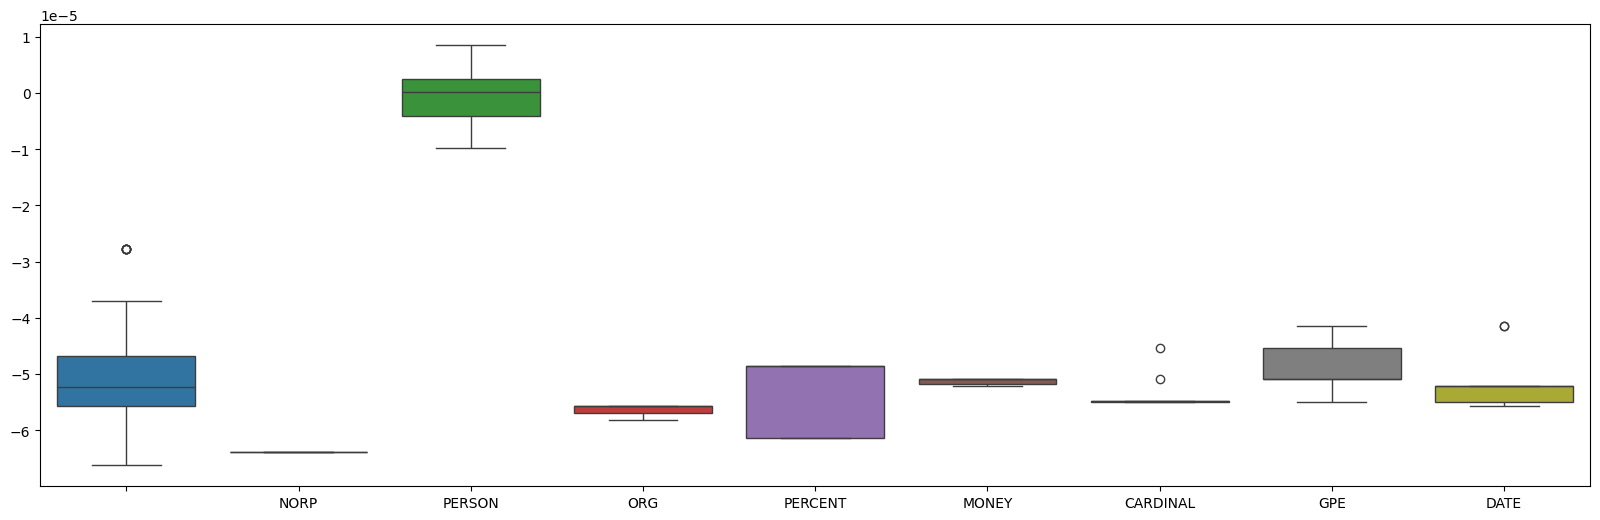

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

all_ner_types = set()

for _,_,ner in token_exp_NERs:
        all_ner_types.add(ner)
        
exps = {}
for ner_type in all_ner_types:
    exps[ner_type] = []



for token,exp,ner in token_exp_NERs:
      exps[ner].append(exp)


plt.figure(figsize=(20,6))
sns.boxplot(exps)